# Data Loading

In [1]:
import pandas as pd

In [3]:
train_data_df = pd.read_csv('../train.csv')

# get the sequence
seq = open('../sequence.fasta', 'r').read()
seq = seq.split("\n")[1]

# create each mutated sequence using the info
sequences = []
for i in train_data_df['mutant']:
    ind = int(i[1:-1])
    tmp = seq[:ind] + i[-1] + seq[ind+1:]
    sequences.append(tmp)
train_data_df['Sequence'] = sequences

In [4]:
train_data_df = train_data_df.rename(columns={'DMS_score': 'labels'})

train_data_df.head()

,mutant,labels,Sequence
0,M0Y,0.2730,YVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1,M0W,0.2857,WVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
2,M0V,0.2153,VVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
3,M0T,0.3122,TVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
4,M0S,0.2180,SVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...


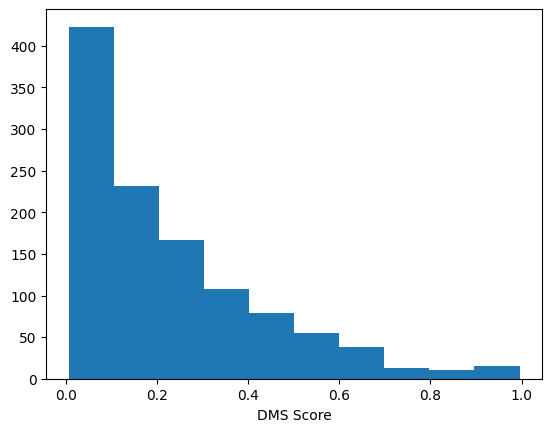

In [6]:
import matplotlib.pyplot as plt

plt.hist(train_data_df["labels"])
plt.xlabel("DMS Score")
plt.show()

# Utils

In [42]:
from scipy.stats import pearsonr

def compute_metrics(p):
    """Compute Pearson correlation for evaluation."""
    predictions, labels = p
    
    # Flatten in case of multi-dimensional outputs
    predictions = predictions.flatten()
    labels = labels.flatten()
    
    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(predictions, labels)
    
    return {'pearson_correlation': pearson_corr}

In [43]:
def compute_loss(model, inputs):
    """Custom compute_loss function for regression."""
    logits = model(**inputs).logits.view(-1)  # Flatten logits
    labels = inputs["labels"].view(-1)  # Flatten labels
    loss_fct = nn.MSELoss()  # Mean Squared Error Loss
    loss = loss_fct(logits, labels)
    return loss

In [44]:
from datasets import Dataset

train_data = Dataset.from_pandas(train_data_df)


In [45]:
train_test_split = train_data.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]


# Data Processing

In [46]:
from datasets import Dataset
from transformers import AutoTokenizer

# Assuming you have the DataFrame `train_data_df`
# Tokenization
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")

# Max sequence length (for example, you can set it based on your sequences' length)
max_sequence_length = 656  # Adjust this based on your data or preference

In [47]:
# Tokenizing the sequences
train_data_tokenized = tokenizer(
    train_dataset["Sequence"],
    max_length=max_sequence_length,
    return_tensors="pt",  # Returns PyTorch tensors
    padding=True,         # Pads the sequences to max length
    truncation=True       # Truncates if the length exceeds max_sequence_length
)
test_data_tokenized = tokenizer(
    test_dataset["Sequence"],
    max_length=max_sequence_length,
    return_tensors="pt",  # Returns PyTorch tensors
    padding=True,         # Pads the sequences to max length
    truncation=True       # Truncates if the length exceeds max_sequence_length
)

train_labels = train_dataset["labels"]
test_labels = test_dataset["labels"]

train_ds = Dataset.from_dict({k: v for k, v in train_data_tokenized.items()}).add_column("labels", train_labels)
test_ds = Dataset.from_dict({k: v for k, v in test_data_tokenized.items()}).add_column("labels", test_labels)


# Train

In [53]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from datetime import datetime
import os

In [74]:
def train_function_no_sweeps(train_dataset, test_dataset):
    
    # Set the LoRA config
    config = {
        "lora_alpha": 1, #try 0.5, 1, 2, ..., 16
        "lora_dropout": 0.2,
        "lr": 5.701568055793089e-04,
        "lr_scheduler_type": "cosine",
        "max_grad_norm": 0.5,
        "num_train_epochs": 3,
        "per_device_train_batch_size": 12,
        "r": 8,
        "weight_decay": 0.2,
        # Add other hyperparameters as needed
    }
    # The base model you will train a LoRA on top of
    model_checkpoint = "facebook/esm2_t12_35M_UR50D"  
    
    # Define labels and model
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1)

    # Convert the model into a PeftModel
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, 
        inference_mode=False, 
        r=config["r"], 
        lora_alpha=config["lora_alpha"], 
        target_modules=["query", "key", "value"], # also try "dense_h_to_4h" and "dense_4h_to_h"
        lora_dropout=config["lora_dropout"], 
        bias="none" # or "all" or "lora_only" 
    )
    model = get_peft_model(model, peft_config)

    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    # Training setup
    training_args = TrainingArguments(
        output_dir=f"esm2_t12_35M-lora-binding-sites_{timestamp}",
        learning_rate=config["lr"],
        lr_scheduler_type=config["lr_scheduler_type"],
        gradient_accumulation_steps=1,
        max_grad_norm=config["max_grad_norm"],
        per_device_train_batch_size=config["per_device_train_batch_size"],
        per_device_eval_batch_size=config["per_device_train_batch_size"],
        num_train_epochs=config["num_train_epochs"],
        weight_decay=config["weight_decay"],
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="pearson_correlation",
        greater_is_better=True,
        push_to_hub=False,
        logging_dir=None,
        logging_first_step=False,
        logging_steps=200,
        save_total_limit=7,
        no_cuda=False,
        seed=8893,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train and Save Model
    trainer.train()
    save_path = os.path.join("lora_binding_sites", f"best_model_esm2_t12_35M_lora_{timestamp}")
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)

In [75]:
train_function_no_sweeps(train_ds, test_ds)



Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2824154/3484572140.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


## Grid Search

In [79]:
import itertools
import os
from datetime import datetime
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import PeftModel, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, matthews_corrcoef
import torch

# Define the grid of hyperparameters to search through
lr_grid = [1e-4, 5e-4, 1e-3]  # Learning rates
lora_alpha_grid = [0.5, 1, 2, 4, 8, 16]  # lora_alpha values
r_grid = [4, 8, 16]  # r values
weight_decay_grid = [0.1, 0.2, 0.3]  # Weight decay values



In [83]:

# Grid search for hyperparameters
def grid_search(train_dataset, test_dataset):
    # Define paths and model configuration
    model_checkpoint = "facebook/esm2_t12_35M_UR50D"
    
    # Prepare grid for hyperparameter search
    param_grid = {
        "lr": lr_grid,
        "lora_alpha": lora_alpha_grid,
        "r": r_grid,
        "weight_decay": weight_decay_grid,
    }

    # Generate all combinations of hyperparameters
    param_combinations = list(itertools.product(*param_grid.values()))
    
    best_metrics = None
    best_params = None

    # Loop over all combinations of hyperparameters
    for params in param_combinations:
        config = {
            "lr": params[0],
            "lora_alpha": params[1],
            "r": params[2],
            "weight_decay": params[3],
            "lora_dropout": 0.2,
            "num_train_epochs": 3,
            "per_device_train_batch_size": 12,
            "max_grad_norm": 0.5,
        }

        # Load the base model and modify for LoRA
        model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1)
        
        # LoRA config
        peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS, 
            inference_mode=False, 
            r=config["r"], 
            lora_alpha=config["lora_alpha"], 
            target_modules=["query", "key", "value"],
            lora_dropout=config["lora_dropout"], 
            bias="none" 
        )
        
        model = get_peft_model(model, peft_config)

        # Create the output path with timestamp
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

        # Setup the Trainer's training arguments
        training_args = TrainingArguments(
            output_dir=f"esm2_t12_35M-lora-binding-sites_{timestamp}",
            learning_rate=config["lr"],
            weight_decay=config["weight_decay"],
            max_grad_norm=config["max_grad_norm"],
            per_device_train_batch_size=config["per_device_train_batch_size"],
            per_device_eval_batch_size=config["per_device_train_batch_size"],
            num_train_epochs=config["num_train_epochs"],
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="pearson_correlation",
            greater_is_better=True,
            logging_dir=None,
            logging_steps=200,
            save_total_limit=7,
            no_cuda=False,
            seed=8893,
        )

        # Initialize Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics
        )

        # Train and evaluate the model
        trainer.train()

        # Evaluate the model on the test dataset
        eval_results = trainer.evaluate()
        print(eval_results)

        # Store the best model and metrics
        if best_metrics is None or eval_results["eval_pearson_correlation"] > best_metrics["eval_pearson_correlation"]:
            best_metrics = eval_results
            best_params = config

        # Save the model after training
        save_path = os.path.join("lora_binding_sites", f"best_model_esm2_t12_35M_lora_{timestamp}")
        trainer.save_model(save_path)
        
    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Metrics: {best_metrics}")

# Run the grid search
grid_search(train_ds, test_ds)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.040679238736629486, 'eval_pearson_correlation': 0.02186392992734909, 'eval_runtime': 2.8973, 'eval_samples_per_second': 78.694, 'eval_steps_per_second': 6.558, 'epoch': 3.0}


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.04067691043019295, 'eval_pearson_correlation': -0.037978529930114746, 'eval_runtime': 3.1294, 'eval_samples_per_second': 72.857, 'eval_steps_per_second': 6.071, 'epoch': 3.0}


/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.04067691043019295, 'eval_pearson_correlation': -0.038028351962566376, 'eval_runtime': 2.6609, 'eval_samples_per_second': 85.686, 'eval_steps_per_second': 7.14, 'epoch': 3.0}


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.04067640379071236, 'eval_pearson_correlation': -0.03632612153887749, 'eval_runtime': 2.9151, 'eval_samples_per_second': 78.214, 'eval_steps_per_second': 6.518, 'epoch': 3.0}


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.04067603498697281, 'eval_pearson_correlation': -0.036020562052726746, 'eval_runtime': 2.835, 'eval_samples_per_second': 80.424, 'eval_steps_per_second': 6.702, 'epoch': 3.0}


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.04067632555961609, 'eval_pearson_correlation': -0.03617993742227554, 'eval_runtime': 2.7299, 'eval_samples_per_second': 83.519, 'eval_steps_per_second': 6.96, 'epoch': 3.0}


/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.040676116943359375, 'eval_pearson_correlation': -0.03620517626404762, 'eval_runtime': 2.6685, 'eval_samples_per_second': 85.442, 'eval_steps_per_second': 7.12, 'epoch': 3.0}


/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.040676262229681015, 'eval_pearson_correlation': -0.03630216792225838, 'eval_runtime': 2.9321, 'eval_samples_per_second': 77.761, 'eval_steps_per_second': 6.48, 'epoch': 3.0}


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.040676411241292953, 'eval_pearson_correlation': -0.03638749569654465, 'eval_runtime': 2.9381, 'eval_samples_per_second': 77.602, 'eval_steps_per_second': 6.467, 'epoch': 3.0}


/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.04067512974143028, 'eval_pearson_correlation': -0.03290513530373573, 'eval_runtime': 2.6475, 'eval_samples_per_second': 86.12, 'eval_steps_per_second': 7.177, 'epoch': 3.0}


/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.040674954652786255, 'eval_pearson_correlation': -0.032617248594760895, 'eval_runtime': 2.7274, 'eval_samples_per_second': 83.595, 'eval_steps_per_second': 6.966, 'epoch': 3.0}


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.04067522659897804, 'eval_pearson_correlation': -0.03297354280948639, 'eval_runtime': 2.6452, 'eval_samples_per_second': 86.195, 'eval_steps_per_second': 7.183, 'epoch': 3.0}


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'eval_loss': 0.04067537188529968, 'eval_pearson_correlation': -0.03306811302900314, 'eval_runtime': 2.702, 'eval_samples_per_second': 84.383, 'eval_steps_per_second': 7.032, 'epoch': 3.0}


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hice1/rmehta98/.conda/envs/compbio/lib/python3.13/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


# Eval

In [76]:
from scipy.stats import pearsonr

def compute_metrics_eval(model, ds):
    """Compute Pearson correlation for evaluation."""
    # Get the predictions using the trained model
    trainer = Trainer(model=model)
    predictions, labels, _ = trainer.predict(test_dataset=ds)
    
    # Remove padding and special tokens
    print(predictions.shape)
    print(labels.shape)

    
    # Flatten in case of multi-dimensional outputs
    predictions = predictions.flatten()
    labels = labels.flatten()
    
    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(predictions, labels)
    
    return {'pearson_correlation': pearson_corr}

In [77]:
from sklearn.metrics import(
    matthews_corrcoef, 
    accuracy_score, 
    precision_recall_fscore_support, 
    roc_auc_score
)
from peft import PeftModel

# Define paths to the LoRA and base models
base_model_path = "facebook/esm2_t12_35M_UR50D"
lora_model_path = "./lora_binding_sites/best_model_esm2_t12_35M_lora_2025-03-30_21-03-25/" # "path/to/your/lora/model" Replace with the correct path to your LoRA model

# Load the base model
base_model = AutoModelForSequenceClassification.from_pretrained(base_model_path, num_labels=1)

# Load the LoRA model
model = PeftModel.from_pretrained(base_model, lora_model_path)

# Get the metrics for the training and test datasets
train_metrics = compute_metrics_eval(model, train_ds)
test_metrics = compute_metrics_eval(model, test_ds)

train_metrics, test_metrics


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(912, 1)
(912,)


(228, 1)
(228,)


({'pearson_correlation': 0.13680005}, {'pearson_correlation': 0.043371588})

# Test Set Output

In [73]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PeftModel
import torch

# Path to the saved LoRA model
model_path = "./lora_binding_sites/best_model_esm2_t12_35M_lora_2025-03-30_20-50-31/"
# ESM2 base model
base_model_path = "facebook/esm2_t12_35M_UR50D"

# Load the model
base_model = AutoModelForSequenceClassification.from_pretrained(base_model_path, num_labels=1)
loaded_model = PeftModel.from_pretrained(base_model, model_path)

# Ensure the model is in evaluation mode
loaded_model.eval()

# Load the tokenizer
loaded_tokenizer = AutoTokenizer.from_pretrained(base_model_path)

# Protein sequence for inference
protein_sequence = "MVNLARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP"  # Replace with your actual sequence

# Tokenize the sequence
inputs = loaded_tokenizer(protein_sequence, return_tensors="pt", truncation=True, max_length=656, padding='max_length')

# Run the model
with torch.no_grad():
    logits = loaded_model(**inputs).logits

print(logits)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[0.2361]])
